# Week4 - Homework

- Execute the below code, then answer the numbered questions.
- You can create additinal code and markdown blocks

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/regression/airbnb_nyc_2019.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
# EDA: Remove duplicates
df.drop_duplicates(inplace=True)

# EDA: Remove rows with missing values
df.dropna(inplace=True)

## Question 1:
### Which features can we use?

In [4]:
# analysis code
features = ['id','host_id','neighbourhood_group', 'neighbourhood' , 'room_type', 'minimum_nights',
            'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
            'availability_365']

#name, host_name - Host names don't directly relate to price.

#latitude, longitude - Thecoordinates don't matter as much as the general neighborhood.

#last_review - Recency of reviews doesn't necessarily affect price.



Your explanation?

In [5]:
from sklearn.model_selection import train_test_split
features = ['id','host_id','neighbourhood_group', 'neighbourhood' , 'room_type', 'minimum_nights',
            'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
            'availability_365']
X = df[features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 31,056
Records in test data: 7,765

Features:
id
host_id
neighbourhood_group
neighbourhood
room_type
minimum_nights
number_of_reviews
reviews_per_month
calculated_host_listings_count
availability_365


## Question 2:
Split the features into two lists, one for the numerical features and another for the categorical features.

In [6]:
# insert code here
numeric_features = ['id', 'host_id', 'minimum_nights', 'number_of_reviews',
                    'reviews_per_month', 'calculated_host_listings_count',
                    'availability_365']

categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']

## Question 3:
 Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [7]:
numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

## Question 4:
Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays.
- You should be dropping one category from each variable when using the one-hot encoder.  
- To ensure the pipeline doesn't break when it receives new/unexpected categories, you should ignore new categories.
- Use a fit transformer on the training dataset to validate all the columns are now numeric and to determine how many columns the transformed data contains.

In [8]:
categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])
categorical_pipeline.fit_transform(X_train[categorical_features])

<31056x220 sparse matrix of type '<class 'numpy.float64'>'
	with 76182 stored elements in Compressed Sparse Row format>

## Question 5:

Combine the numerical and categorical pipelines into one data processing pipeline.
- Use a fit transformers and the training dataset to verify the data has no missing values and the correct number of columns.

In [9]:
import numpy as np

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
# Fit transformers on the training data
X_train_filtered = preprocessor.fit_transform(X_train)

print("Processed data shape:", X_train_filtered.shape)

X_train_filtered_dense = X_train_filtered.toarray()

num_missing_values = np.count_nonzero(np.isnan(X_train_filtered_dense))

print("Number of missing values:", num_missing_values)

Processed data shape: (31056, 227)
Number of missing values: 0


## Question 6:

Add a linear regression model to the pipeline.
- Report what the $R^2$ is using the `test` data.  

In [10]:
# Append linear regression to preprocessing pipeline
regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Fit pipeline
regression_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = regression_pipeline.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(r2)

0.12846340225416808


/Users/saiakhilsadula/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Question 7:

Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?
- Include a sentence or two on what you observe.

In [11]:
y_pred = y_pred.ravel()

/Users/saiakhilsadula/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


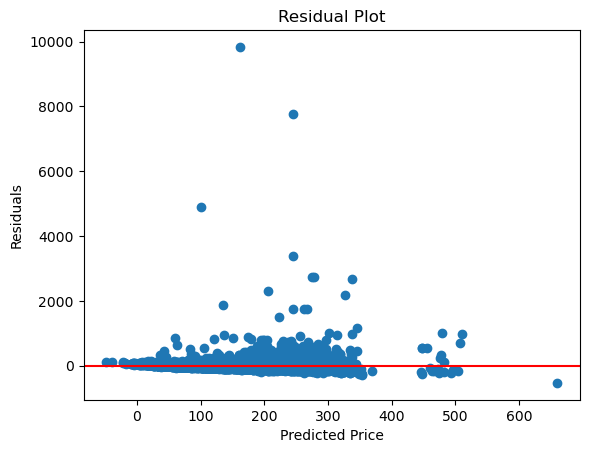

In [12]:
import matplotlib.pyplot as plt
y_pred = regression_pipeline.predict(X_test)

residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

If the residuals exhibit a clear pattern or structure, it tells that the model is neglecting to capture some relationship in the data and the residuals are randomly scattered around the horizontal line at 0, it indicates that the model's predictions are unbiased and the residuals have constant variance, which is desirable.

## Question 8:

Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the $R^2$?

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


categorical_features = ['neighbourhood_group', 'room_type']
numeric_features = ['minimum_nights',
                    'number_of_reviews', 'reviews_per_month',
                    'calculated_host_listings_count', 'availability_365']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=100))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred_ridge = pipeline.predict(X_test)

# Calculate the R^2 score
r2_ridge = r2_score(y_test, y_pred_ridge)

# Print the R^2 score
print("R^2 score with Ridge regression (alpha=100):", r2_ridge)


NameError: name 'Ridge' is not defined